In [1]:
 # https://keras.io/examples/rl/ddpg_pendulum/

In [2]:
import gym
import tensorflow as tf
import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path

class custom_PendulumEnv(gym.Env):
    metadata = {
        'render.modes' : ['human', 'rgb_array'],
        'video.frames_per_second' : 30
    }

    def __init__(self):
        self.max_speed=8
        self.max_torque=2.
        self.dt=.05
        self.viewer = None
        self.max_step = 200
        self.current_step = 0

        high = np.array([1., 1., self.max_speed])
        self.action_space = spaces.Box(low=-self.max_torque, high=self.max_torque, shape=(1,))
        self.observation_space = spaces.Box(low=-high, high=high)

        self.seed()

        ### Customization changes ############################
        '''add ElectricalDCMotorEnv to the CartPole class
        and assign values to
        Resistor_R, inductor_L, torque_const_Kt and bemf_const_Ke'''

        self.tau1 = .05  # seconds between state updates
        self.DCMotorModel = ElectricalDCMotorEnv()
        self.DCMotorModel.tau1 = self.tau1
        self.DCMotorModel.Resistor_R = 1.0
        self.DCMotorModel.inductor_L = 0.1
        self.DCMotorModel.torque_const_Kt = 1.0
        self.DCMotorModel.bemf_const_Ke = 1.0
        ####


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self,u):
        th, thdot = self.state # th := theta

        g = 10.
        m = 1.
        l = 1.
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0] #numpy.clip() function is used to Clip (limit) the values in an array
        current_ref = u/self.DCMotorModel.torque_const_Kt
        u_after_pid = self.DCMotorModel.step(current_ref = current_ref, theta_dot = thdot)
        #u_after_pid=u #change for perfect appying torque
        u_after_pid = [u_after_pid]
        u_after_pid = np.clip(u_after_pid, -self.max_torque, self.max_torque)[0]

        self.last_u = u_after_pid
        costs = angle_normalize(th)**2 + .1*thdot**2 + .001*(u_after_pid**2)


        newthdot = thdot + (-3*g/(2*l) * np.sin(th + np.pi) + 3./(m*l**2)*u_after_pid) * dt
        newth = th + newthdot*dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed) #pylint: disable=E1111 #numpy.clip() function is used to Clip (limit) the values in an array

        self.state = np.array([newth, newthdot])

        self.current_step += 1
        done = bool(self.current_step % self.max_step == 0)

        return self._get_obs(), -costs, done, {} , u , u_after_pid

    def reset(self):
        high = np.array([np.pi, 1])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None

        self.DCMotorModel.current = 0.0
        self.DCMotorModel.current_error = 0.0
        self.DCMotorModel.current_error_acc = 0.0
        self.DCMotorModel.current_error_prev = 0.0

        return self._get_obs()

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot])

    def render(self, mode='human'):

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(500,500)
            self.viewer.set_bounds(-2.2,2.2,-2.2,2.2)
            rod = rendering.make_capsule(1, .2)
            rod.set_color(.8, .3, .3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(.05)
            axle.set_color(0,0,0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1., 1.)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi/2)
        if self.last_u:
            self.imgtrans.scale = (-self.last_u/2, np.abs(self.last_u)/2)

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer: self.viewer.close()

def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class ElectricalDCMotorEnv():

      def __init__(self):
        self.Resistor_R = 1.0
        self.inductor_L = 0.1
        self.torque_const_Kt = 1.0
        self.bemf_const_Ke = 1.0
        self.tau1 = 0.05
        #
        self.Kp = 1.0
        self.Ki = 20.0
        self.Kd = 10**(-6)
        self.aL=10.0**(-3) #Low pass parameter
        self.aH = 10.0**2 #High pass parameter

        #
        self.current = 0.0
        self.current_error = 0.0
        self.current_error_acc = 0.0
        self.current_error_prev = 0.0
        self.voltage_input = 0.0
        self.thetadot = 0.0
        self.PID_Discretization = "Simple" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"

      def step(self, current_ref, theta_dot):
        aL = self.aL
        aH = self.aH
        self.current_error = current_ref-self.current
        delta_error = self.current_error-self.current_error_prev

        if self.PID_Discretization == "Simple":
          self.current_error_acc += self.current_error*self.tau1
          HP_delta_error = delta_error

        elif self.PID_Discretization == "Backward":
          self.current_error_acc = (self.current_error_acc+(self.current_error)*self.tau1)/(1+aL*self.tau1)
          HP_delta_error = (self.current_error + aH*delta_error)/(1+aL*self.tau1)#High Pass

        elif self.PID_Discretization == "Bilinear":
          error_avg = (self.current_error+self.current_error_prev)/2
          self.current_error_acc =  ((1-aL*self.tau1/2)*self.current_error_acc + error_avg*self.tau1)/(1+aL*self.tau1/2)#Low Pass
          HP_delta_error =  ((1-aL*self.tau1/2)*self.current_error + aH*delta_error)/(1+aL*self.tau1/2)#High Pass

        else:
          self.current_error_acc = (1-aL*self.tau1)*self.current_error_acc+(self.current_error_prev)*self.tau1 #Low Pass
          HP_delta_error = (1-aH*self.tau1)*self.current_error + aH*delta_error #High Pass

        P = self.Kp*self.current_error
        I = self.Ki*self.current_error_acc
        D = self.Kd*HP_delta_error/self.tau1
        voltage_BEMF = theta_dot*self.bemf_const_Ke
        voltage_input = P+I+D+voltage_BEMF
        voltage_input = np.clip(voltage_input, -10, 10)

        self.current_error_prev = 0+self.current_error
        self.current += self.tau1*(voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L

        self.voltage_input = voltage_input
        self.thetadot = theta_dot
        F = self.torque_const_Kt*self.current

        return F # return applied Tourqe

In [5]:
env = custom_PendulumEnv()
env.DCMotorModel.PID_Discretization ="Simple" # "Forward" or "Backward" or" "Bilinear" or "Simple"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [6]:
'''
problem = "Pendulum-v1"
env = gym.make(problem)
'''


num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [7]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [9]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -keras.ops.mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)

In [10]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    #state_input = layers.Input(shape=(num_states))
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    #action_input = layers.Input(shape=(num_actions))
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [11]:

def policy(state, noise_object):
    #print("state",state)
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound) #numpy.clip() function is used to Clip (limit) the values in an array

    return [np.squeeze(legal_action)]


In [12]:
critic_model = get_critic()

In [13]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 500
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

In [14]:
#######################################################tests
prev_state = env.reset()
print(prev_state)
print(type(prev_state))

[0.96598298 0.25860564 0.89629425]
<class 'numpy.ndarray'>


In [15]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []


save_observation = []
save_u1 = []
save_pid_u1 = []




# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)

        # Recieve state and reward from environment.
        state, reward, done, info , u , u_after_pid = env.step(action)


        if ep == total_episodes - 1 :
          save_observation.append(state)
          save_u1.append(u)
          save_pid_u1.append(u_after_pid)


        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        #update_target(target_actor.variables, actor_model.variables, tau)
        #update_target(target_critic.variables, critic_model.variables, tau)
        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, f"{avg_reward:.3f}"))
    avg_reward_list.append(avg_reward)



Episode * 0 * Avg Reward is ==> -1601.333
Episode * 1 * Avg Reward is ==> -1387.639
Episode * 2 * Avg Reward is ==> -1530.212
Episode * 3 * Avg Reward is ==> -1542.309
Episode * 4 * Avg Reward is ==> -1428.344
Episode * 5 * Avg Reward is ==> -1417.276
Episode * 6 * Avg Reward is ==> -1412.687
Episode * 7 * Avg Reward is ==> -1385.367
Episode * 8 * Avg Reward is ==> -1388.183
Episode * 9 * Avg Reward is ==> -1369.855
Episode * 10 * Avg Reward is ==> -1339.359
Episode * 11 * Avg Reward is ==> -1316.955
Episode * 12 * Avg Reward is ==> -1274.570
Episode * 13 * Avg Reward is ==> -1271.574
Episode * 14 * Avg Reward is ==> -1259.973
Episode * 15 * Avg Reward is ==> -1249.640
Episode * 16 * Avg Reward is ==> -1244.954
Episode * 17 * Avg Reward is ==> -1244.190
Episode * 18 * Avg Reward is ==> -1248.599
Episode * 19 * Avg Reward is ==> -1253.217
Episode * 20 * Avg Reward is ==> -1256.289
Episode * 21 * Avg Reward is ==> -1264.762
Episode * 22 * Avg Reward is ==> -1261.534
Episode * 23 * Avg Re

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


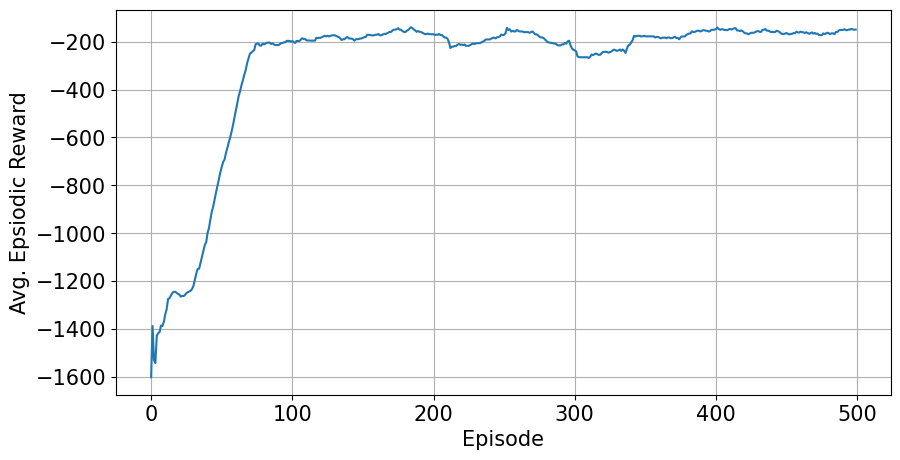

In [16]:
# Plotting graph
# Episodes versus Avg. Rewards
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.grid()
plt.show()

In [26]:
# Save the weights
actor_model.save_weights("pendulum_actor.weights.h5")
critic_model.save_weights("pendulum_critic.weights.h5")

target_actor.save_weights("pendulum_target_actor.weights.h5")
target_critic.save_weights("pendulum_target_critic.weights.h5")

In [18]:
#!pip install latex

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
dt = env.dt
#dt=0.05

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


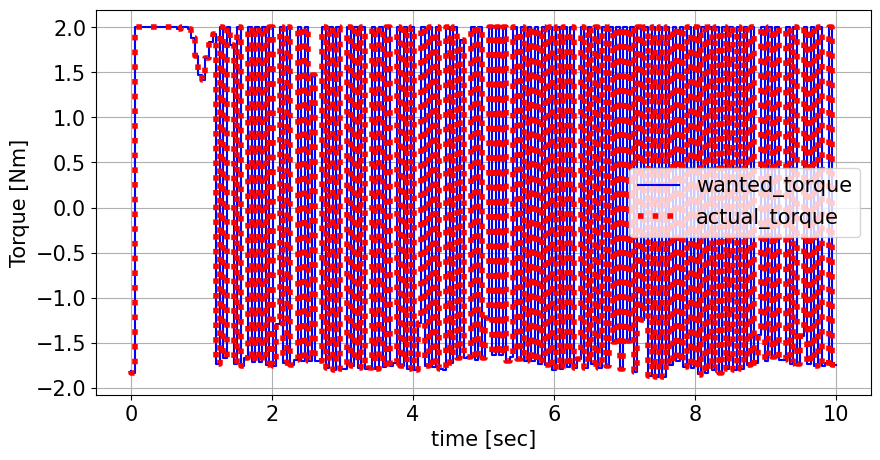

In [29]:
time_position_u1= np.linspace(start = 0, stop = len(save_u1)* dt,num=len(save_u1) )
time_position__pid_u1= np.linspace(start = 0, stop = len(save_u1)* dt,num=len(save_u1) )

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.step(time_position_u1, save_u1 ,label = "wanted_torque",color="blue",linewidth = 1.5)
plt.step(time_position__pid_u1, save_pid_u1 , ':',label = "actual_torque",color="red",linewidth = 4)
plt.xlabel("time [sec]")
plt.ylabel("Torque [Nm]")
plt.legend()
plt.grid()
plt.show()

In [30]:
import math

x_print = []
y_print = []
thetadot_print = []

for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      x_print.append(value)
      #theta_print.append(math.acos(value))
    if index == 1:
      y_print.append(value)
    if index == 2:
      thetadot_print.append(value)

theta_print = list(np.arctan2(np.array(y_print), np.array(x_print)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
print(len(x_print))

200


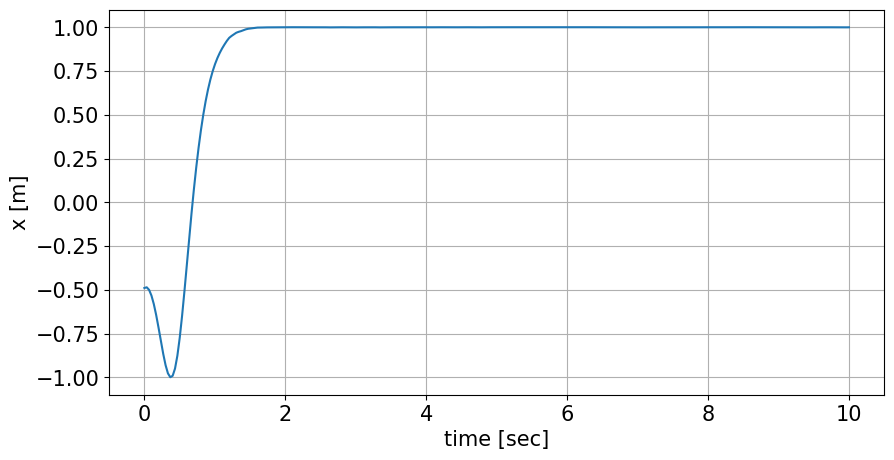

In [32]:
from scipy.interpolate import make_interp_spline, BSpline

time_x_print = np.linspace(start = 0, stop = len(x_print)* dt,num=len(x_print))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_x_print[-1] , 300)

spl = make_interp_spline(time_x_print, x_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(xnew, power_smooth)
plt.xlabel("time [sec]")
plt.ylabel("x [m]")
plt.grid()
plt.show()

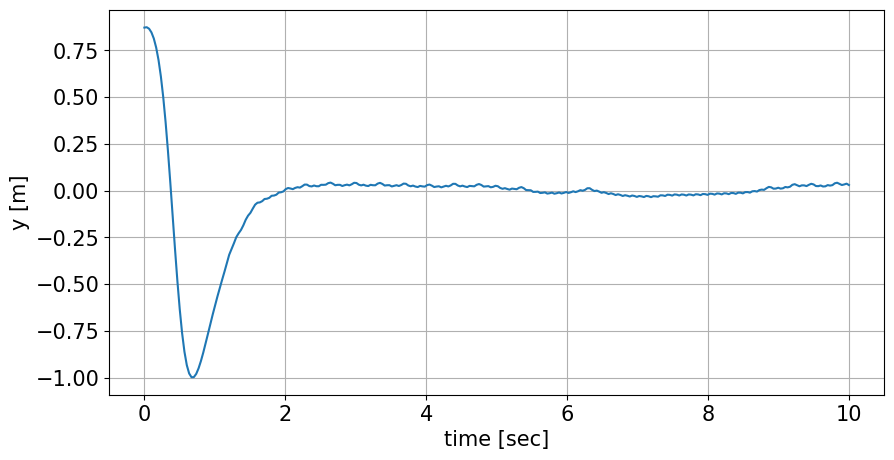

In [33]:
from scipy.interpolate import make_interp_spline, BSpline

time_y_print = np.linspace(start = 0, stop = len(y_print)* dt,num=len(y_print))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_y_print[-1] , 300)

spl = make_interp_spline(time_y_print, y_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(xnew, power_smooth)
plt.xlabel("time [sec]")
plt.ylabel("y [m]")
plt.grid()
plt.show()

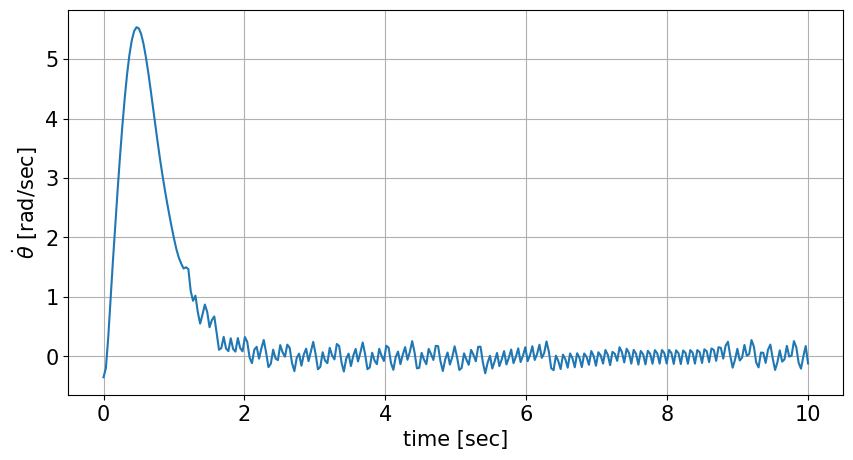

In [34]:
from scipy.interpolate import make_interp_spline, BSpline

time_thetadot_print = np.linspace(start = 0, stop = len(thetadot_print)* dt,num=len(thetadot_print))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_thetadot_print[-1] , 300)

spl = make_interp_spline(time_thetadot_print, thetadot_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(xnew, power_smooth)
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\dot{\theta}$ [rad/sec]')
plt.grid()
plt.show()

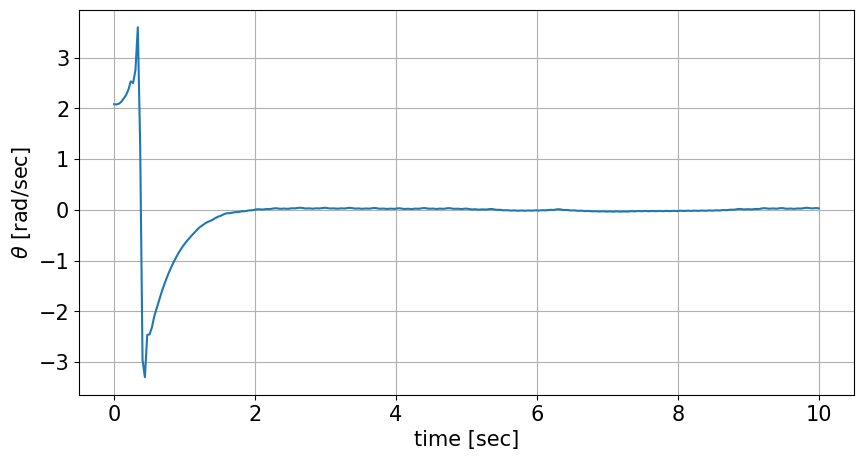

In [35]:
time_theta_print = np.linspace(start = 0, stop = len(theta_print)* dt,num=len(theta_print))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_theta_print[-1] , 300)

spl = make_interp_spline(time_theta_print, theta_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(xnew, power_smooth)
plt.xlabel("time [sec]")
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.ylabel(r'$\theta$ [rad/sec]')
plt.grid()
plt.show()